In [ ]:
%%capture
%run '/content/drive/MyDrive/Federated_Learning/CIFAR-10/NonIID/DirichletPartition/Decentralized/Dirichlet_Requirement.ipynb'

In [3]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [4]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [6]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [7]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [8]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [9]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [10]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=30)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [11]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [12]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=30, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1587) 2025-04-28 12:26:26.126190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1586) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1586) E0000 00:00:1745843186.204505    1586 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1586) E0000 00:00:1745843186.216695    1586 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1587) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 10881000487987240780, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 98835.78 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881


(ClientAppActor pid=1586) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1586) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1586) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1586) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1586) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1586)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 7
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.4449
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1586) Partition 5 size: 4272 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 9 train size: 3523


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Partition 5 test size: 855
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Accuracy: 0.4787
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) Partition 5 test size: 855
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=158

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.5603
(ClientAppActor pid=1587) Partition 7 size: 6226 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 7 train size: 4980 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 7 test size: 1246 [repeated 2x across cluster]
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 0 train size: 379
(ClientAppActor pid=1586) Partition 0 test size: 95
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.7499
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   c

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.6994
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.5954
(ClientAppActor pid=1587) Partition 0 size: 474 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 0 train size: 379 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 0 test size: 95 [repeated 2x across cluster]
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 9 size: 4404 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 9 train size: 3523 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.6002
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 150254976356

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.6135
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.7918
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 7 size: 6226
(ClientAppActor pid=1586) Partition 7 train size: 4980
(ClientAppActor pid=1586) Partition 7 test size: 1246
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Partition 7 size: 6226
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_re

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Accuracy: 0.5416
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Accuracy: 0.6540
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=158

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Accuracy: 0.7849
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientAppActor pid=1587) Partition 0 size: 474 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 0 train size: 379 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Accuracy: 0.5822
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) Partition 5 test size: 855
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Accuracy: 0.6986
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Accuracy: 0.7421
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 0 train size: 379
(ClientAppActor pid=1586) Partition 0 test size: 95
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Accuracy: 0.7151
(ClientAppActor pid=1587) Partition 7 size: 6226 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 7 train size: 4980 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 7 test size: 1246 [repeated 2x across cluster]
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Partition 5 test size: 855
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Test Accuracy: 0.6275
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Accuracy: 0.7391
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 0 train size: 379
(ClientAppActor pid=1586) Partition 0 test size: 95
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Accuracy: 0.8163
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Pa

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Accuracy: 0.7090
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Accuracy: 0.7159
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 1769399689767401677, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 7
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(Clie

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Accuracy: 0.8034
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1587) Partition 5 size: 4272
(ClientAppActor pid=1587) Partition 5 train size: 3417
(ClientAppActor pid=1587) Pa

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 7
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 0 train size: 379
(ClientAppActor pid=1586) Partition 0 test size: 95
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 7 train size: 4980
(ClientAppActor pid=1586) Partition 7 test size: 1246
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_reco

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Accuracy: 0.8595
(ClientAppActor pid=1587) Partition 0 train size: 379 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 0 test size: 95 [repeated 2x across cluster]
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 0 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 7 size: 6226 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 7 train size: 4980 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 7 test size: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1587) Partition 7 size: 6226
(ClientAppActor pid=1587) Partition 7 train size: 4980
(ClientAppActor pid=1587) Partition 7 test size: 1246
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 3x across cluster]
(ClientAppActor pid=1586)   array_records={}, [repeated 

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Accuracy: 0.8677
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 7
(ClientAppActor pid=1586) Partition 0 size: 474
(ClientAppActor pid=1586) Partition 0 train size: 379
(ClientAppActor pid=1586) Partition 0 test size: 95
(ClientAppActor pid=1586) Partition 7 size: 6226
(ClientAppActor pid=1586) Partition 7 train size: 4980
(ClientAppActor pid=1586) Partition 7 test size: 1246
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Accuracy: 0.7700
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 7
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) P

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Accuracy: 0.6140
(ClientAppActor pid=1586) Partition 1 size: 940 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 1 train size: 752 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 1 test size: 188 [repeated 2x across cluster]
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1586)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1586)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1586)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1586) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1586) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 5 size: 4272 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 5 train size: 3417 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Partition 0 size: 474
(ClientAppActor pid=1587) Partition 0 train size: 379
(ClientAppActor pid=1587) Partition 0 test size: 95
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_recor

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Accuracy: 0.6569
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 0
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 9
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Accuracy: 0.7663
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 14703370602503592527, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 7
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 18061958311071530290, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 0
(ClientAppActor pid=1587) Partition 0 size: 474 [repeated 2x across cluster]
(ClientAppActor pid=1587) Partition 0 train size: 379

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 8251474380732934449, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 9
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1587)   array_records={},
(ClientAppActor pid=1587)   metric_records={},
(ClientAppActor pid=1587)   config_records={}
(ClientAppActor pid=1587) ), 'run_config': {}}
(ClientAppActor pid=1587) Using partition_id: 5
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Accuracy: 0.7095
(ClientAppActor pid=1586) Partition 9 train size: 3523
(ClientAppActor pid=1586) Partition 9 test size: 881
(ClientAppActor pid=1587) Context data: {'run_id': 15025497635660325256, 'node_id': 14381909567006221649, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1587)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1587)   config_records={} [repeated 2x across cluster]
(ClientAppActor pid=1587) ), 'run_config': {}} [repeated 2x across cluster]
(ClientAppActor pid=1587) Using partition_id: 9 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 size: 4404
(ClientAppActor pid=1587) Partition 9 train size: 3523
(ClientAppActor pid=1587) Partition 9 test size: 881
(ClientAppActor pid=1586) Context data: {'run_id': 1502549763

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 2294612728839989295, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1586)   array_records={},
(ClientAppActor pid=1586)   metric_records={},
(ClientAppActor pid=1586)   config_records={}
(ClientAppActor pid=1586) ), 'run_config': {}}
(ClientAppActor pid=1586) Using partition_id: 5
(ClientAppActor pid=1586) Partition 5 size: 4272
(ClientAppActor pid=1586) Partition 5 train size: 3417
(ClientAppActor pid=1586) Partition 5 test size: 855
(ClientAppActor pid=1586) Context data: {'run_id': 15025497635660325256, 'node_id': 5252897871505320210, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict( [repeated 2x across cluster]
(ClientAppActor pid=1586)   array_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1586)   metric_records={}, [repeated 2x across cluster]
(ClientAppActor pid=1586)   config_records={} [repeated 2x ac

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 5822.59s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05880159253759018
INFO :      		round 2: 0.04194211563817919
INFO :      		round 3: 0.034228144000837214
INFO :      		round 4: 0.026067243144685705
INFO :      		round 5: 0.03173149857454949
INFO :      		round 6: 0.031261037544779484
INFO :      		round 7: 0.030515695042212947
INFO :      		round 8: 0.02951709090660362
INFO :      		round 9: 0.023989373264546976
INFO :      		round 10: 0.035815820669733725
INFO :      		round 11: 0.028390284152820102
INFO :      		round 12: 0.022901449322446234
INFO :      		round 13: 0.03453159028348987
INFO :      		round 14: 0.027020801167633605
INFO :      		round 15: 0.025034225436967806
INFO :      		round 16: 0.02593195732669797
INFO :      		round 17: 0.02864943910567081
INFO :      		round 18: 0.02467617526001107
INFO :      		r

Round 30: Test Accuracy: 0.7534
(ClientAppActor pid=1586) Partition 1 size: 940 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 1 train size: 752 [repeated 2x across cluster]
(ClientAppActor pid=1586) Partition 1 test size: 188 [repeated 2x across cluster]


In [13]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.4449
Round 2: 0.4787
Round 3: 0.5603
Round 4: 0.7499
Round 5: 0.6994
Round 6: 0.5954
Round 7: 0.6002
Round 8: 0.6135
Round 9: 0.7918
Round 10: 0.5416
Round 11: 0.6540
Round 12: 0.7849
Round 13: 0.5822
Round 14: 0.6986
Round 15: 0.7421
Round 16: 0.7151
Round 17: 0.6275
Round 18: 0.7391
Round 19: 0.8163
Round 20: 0.7090
Round 21: 0.7159
Round 22: 0.8034
Round 23: 0.8595
Round 24: 0.8677
Round 25: 0.7700
Round 26: 0.6140
Round 27: 0.6569
Round 28: 0.7663
Round 29: 0.7095
Round 30: 0.7534



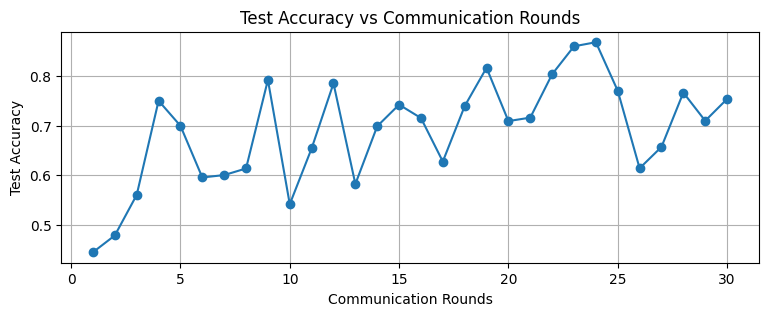

In [14]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

In [ ]:
test_accuracies = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            print(f"Round {server_round}: Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
    initial_parameters=ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=7891) 2025-04-27 17:14:24.787456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7891) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=7891) E0000 00:00:1745774064.818402    7891 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7891) E0000 00:00:1745774064.828233    7891 cuda_blas.cc:1418] Unable to register cuBLAS factory: A

(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Accuracy: 0.2516
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7891) Partition 1 size: 940
(ClientAppActor pid=7891) Partition 1 train size: 752
(ClientAppActor pid=7891) Partition 1 test size: 188
Round 2: Test Accuracy: 0.4410
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientAppActor pid=7891) Partition 4 size: 7143
(ClientAppActor pid=7891) Partition 4 train size: 5714
(ClientAppActor pid=7891) Partition 4 test size: 1429
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 10733627783375289516, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppA

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientAppActor pid=7891) Partition 0 size: 474
(ClientAppActor pid=7891) Partition 0 train size: 379
(ClientAppActor pid=7891) Partition 0 test size: 95
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 2
(ClientAppActo

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Accuracy: 0.2609
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientAppActor pid=7891) Partition 0 size: 474
(ClientAppActor pid=7891) Partition 0 train size: 379
(ClientAppActor pid=7891) Partition 0 test size: 95
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 10733627783375289516, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 6
(ClientAp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Test Accuracy: 0.4339
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientAppActor pid=7891) Partition 4 size: 7143
(ClientAppActor pid=7891) Partition 4 train size: 5714
(ClientAppActor pid=7891) Partition 4 test size: 1429
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5016312863622385614, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Accuracy: 0.5955
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 2
(ClientAppActor pid=7891) Partition 2 size: 2133
(ClientAppActor pid=7891) Partition 2 train size: 1706
(ClientAppActor pid=7891) Partition 2 test size: 427
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5016312863622385614, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Us

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 2
(ClientAppActor pid=7891) Partition 2 size: 2133
(ClientAppActor pid=7891) Partition 2 train size: 1706
(ClientAppActor pid=7891) Partition 2 test size: 427
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5016312863622385614, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientAppA

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Accuracy: 0.5943
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientAppActor pid=7891) Partition 0 size: 474
(ClientAppActor pid=7891) Partition 0 train size: 379
(ClientAppActor pid=7891) Partition 0 test size: 95
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 10733627783375289516, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 6
(ClientAppAct

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Test Accuracy: 0.3146
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 10733627783375289516, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 6
(ClientAppActor pid=7891) Partition 6 size: 570
(ClientAppActor pid=7891) Partition 6 train size: 456
(ClientAppActor pid=7891) Partition 6 test size: 114
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientAppAc

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Accuracy: 0.6784
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 4
(ClientApp

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Accuracy: 0.6343
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 16218270006407809589, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 9
(ClientAppActor pid=7891) Partition 9 size: 4404
(ClientAppActor pid=7891) Partition 9 train size: 3523
(ClientAppActor pid=7891) Partition 9 test size: 881
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 1180042420006450154, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) U

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=7891) Partition 0 size: 474
(ClientAppActor pid=7891) Partition 0 train size: 379
(ClientAppActor pid=7891) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 5443668437268657710, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 0
(ClientAppActor pid=7891) Partition 0 size: 474
(ClientAppActor pid=7891) Partition 0 train size: 379
(ClientAppActor pid=7891) Partition 0 test size: 95
(ClientAppActor pid=7891) Context data: {'run_id': 359242775782979700, 'node_id': 4698617034793720932, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=7891)   array_records={},
(ClientAppActor pid=7891)   metric_records={},
(ClientAppActor pid=7891)   config_records={}
(ClientAppActor pid=7891) ), 'run_config': {}}
(ClientAppActor pid=7891) Using partition_id: 2
(ClientAppActo

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 935.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06690836927450197
INFO :      		round 2: 0.052100621535788316
INFO :      		round 3: 0.05533223012244605
INFO :      		round 4: 0.0495263480172005
INFO :      		round 5: 0.038704703866533914
INFO :      		round 6: 0.04139939766778483
INFO :      		round 7: 0.04950350714528688
INFO :      		round 8: 0.029314399415004556
INFO :      		round 9: 0.03133658773762121
INFO :      		round 10: 0.0498957360912607
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.2515970163176026),
INFO :      	              (2, 0.44096101684235073),
INFO :      	              (3, 0.26088751414503053),
INFO :      	              (4, 0.43394408053991906),
INFO :      	              (5, 0.5955213785367414),
INFO :      	              (6, 0.5942785761558462),
INFO : 

(ClientAppActor pid=7891) Partition 1 size: 940
(ClientAppActor pid=7891) Partition 1 train size: 752
(ClientAppActor pid=7891) Partition 1 test size: 188
Round 10: Test Accuracy: 0.5987


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.2516
Round 2: 0.4410
Round 3: 0.2609
Round 4: 0.4339
Round 5: 0.5955
Round 6: 0.5943
Round 7: 0.3146
Round 8: 0.6784
Round 9: 0.6343
Round 10: 0.5987



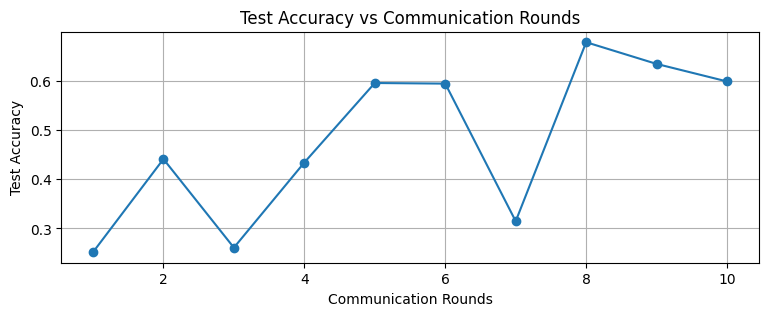

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.savefig('accuracy_vs_rounds.png')
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()